In [29]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy import asarray

from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing import sequence
from unidecode import unidecode
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.layers import GaussianNoise
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing import sequence

from os.path import isfile
import os
import pickle
import sys
from nltk.tokenize import word_tokenize
from unidecode import unidecode
# from tf_data import TF_Data

# Bring dataset

In [30]:
data_file="Combined_News_DJIA.csv"
df = pd.read_csv(data_file)
len(df)

1989

# Keep Small part of the dataset 

In [31]:
df=df[:100]

# Concat all top 25 headlines

In [32]:
def str_join(df, sep, *cols):
    from functools import reduce
    return reduce(lambda x, y: x.astype(str).str.cat(y.astype(str), sep=sep), 
                [df[col] for col in cols])
        

In [33]:
headlines = df[['Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8', 'Top9', 'Top10', 'Top11', 'Top12','Top13', 'Top14', 'Top15', 'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23','Top24', 'Top25']].apply(lambda x: ' '.join(el if type(el) is str else '' for el in x), axis=1)

dataset = pd.concat([df['Date'], df['Label'], headlines], axis=1, keys=['Date', 'Label', 'headlines'])
df= dataset

In [35]:
dataset=df["headlines"].tolist()
print ("The length of the dataset is : ",len(dataset))

('The length of the dataset is : ', 100)


In [36]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.tokenize import sent_tokenize
# nltk.download()

stopWords = set(stopwords.words('english'))

tokenizer = RegexpTokenizer(r'\w+')
# Tokenize
df["headlines"]=df.apply(lambda row: tokenizer.tokenize(row['headlines'] ), axis=1)
# Delete Stop Words
df["headlines"]=df['headlines'].apply(lambda x: [item for item in x if item.lower() not in stopWords])


In [37]:
temp=df["headlines"].tolist()

train_size = int(len(df) * 0.70)
test_size = len(df) - train_size

training_data=temp[:train_size]
print type(training_data)

training_data = [item.lower() for sublist in training_data for item in sublist]

dictionary = pd.Series(training_data).value_counts()
type(dictionary)

<type 'list'>


pandas.core.series.Series

# Frequency of each Word

In [38]:
dictionary

b                1751
us                164
russia            122
u                 110
georgia            99
war                88
world              75
pakistan           71
russian            69
says               68
new                67
israel             59
uk                 56
china              53
iran               51
people             47
military           47
government         46
south              45
year               44
attack             43
nuclear            43
israeli            40
killed             39
afghanistan        38
troops             36
president          35
iraq               35
two                34
1                  32
                 ... 
crowded             1
cyberalliance       1
photoshop           1
mcdonalds           1
insufferable        1
prosecutor          1
scott               1
scientist           1
preempt             1
disabled            1
setback             1
september           1
wangchuck           1
reopening           1
infant    

In [40]:
stop=dictionary[2099:].keys().tolist()
stop

['went',
 'person',
 'edge',
 'bases',
 'deny',
 'officially',
 'visits',
 'stranded',
 'osama',
 'northern',
 'sweden',
 'newly',
 'gov',
 'taiwan',
 'prisoner',
 'novel',
 'megan',
 'liquids',
 'flag',
 'strategy',
 'bombed',
 'else',
 'islanders',
 'justice',
 'exile',
 'economist',
 'babies',
 'content',
 '2003',
 'prior',
 'century',
 'balance',
 'leaving',
 'behavior',
 'hackers',
 'airstrikes',
 'headed',
 'replaced',
 'billions',
 'warships',
 'apparently',
 'facts',
 'uganda',
 'resident',
 'sweet',
 'prosecute',
 'spread',
 'supported',
 'strategic',
 'kgb',
 'fleet',
 'saved',
 'press',
 'affected',
 'warfare',
 'guide',
 'architecture',
 'downs',
 'development',
 'healthy',
 'advocate',
 'er',
 'teenager',
 'acre',
 'driving',
 'meat',
 'wasteland',
 'clash',
 'value',
 'ip',
 'criticizing',
 'elections',
 'unlikely',
 'smoking',
 'affair',
 'phelps',
 'assassination',
 'hidden',
 'restricted',
 'tales',
 'firm',
 'mountain',
 'governor',
 'ordering',
 'drive',
 'source',
 

In [41]:
k=df["headlines"].apply(lambda x: [item for item in x if item.lower() not in stop])
k=k.apply(lambda x: [item for item in x if item.lower() not in stop])
k=k.apply(lambda x: [item.lower() for item in x if item.lower() not in ["u","b"]])

# print k

In [16]:
dataset=k.tolist()
type(k)

pandas.core.series.Series

In [17]:
# k[0][1]
len(k)

100

In [42]:
max_index=0
mean=0
for a in k:
    mean=mean+max_index
    if len(a)>max_index :
        print len(a)
        max_index=len(a)

mean_headline=float(mean)/float(len(k))
print ("the maximum length of a headline is : ", max_index)
print ("the mean length οf the headlines is : ",mean_headline )

206
207
213
217
('the maximum length of a headline is : ', 217)
('the mean length \xce\xbff the headlines is : ', 205.64)


In [19]:
len(dataset)

100

In [43]:
ds=[]
for i in k:
    ds.append(str(i))
dataset=ds

MAX_NB_WORDS=217
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(dataset)
data = np.zeros((len(dataset),MAX_NB_WORDS),dtype="int32")

/Users/evgenia/anaconda/lib/python2.7/site-packages/keras/preprocessing/text.py:145: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


# each word of the headlines ---> to a unique ID

In [46]:
ln=[]
for i, sentences in enumerate(dataset):
    if i< MAX_NB_WORDS:
        wordTokens = text_to_word_sequence(sentences)
        k=0 
        ln.append(len(wordTokens))
        for _, word in enumerate(wordTokens):
            data[i,k] = tokenizer.word_index[word]
            k=k+1

In [47]:
data 

array([[   6,   38,    9, ...,    0,    0,    0],
       [1668,  169,  136, ...,    0,    0,    0],
       [1002, 1673,  138, ...,    0,    0,    0],
       ...,
       [3360,  781,   25, ...,    0,    0,    0],
       [ 218,    3,  115, ...,    0,    0,    0],
       [ 197,  405,  529, ..., 1077,  484, 1265]], dtype=int32)

In [48]:
data.shape

(100, 217)

In [49]:
word_index=tokenizer.word_index
len(word_index)

3463

In [51]:
embeddings_index = {}
GLOVE_DIR="./"
GLOVE_FILE="glove.6B.50d.txt"
words_in_glove = []
f = open(os.path.join(GLOVE_DIR, GLOVE_FILE))
for line in f:
    values = line.split()
    if len(values)>0:
        word = values[0]
        words_in_glove.append(word)
        coefs = np.asarray(values[1:], dtype='float32')
#         print coefs.shape
        embeddings_index[word] = coefs
f.close()

In [30]:
words_in_glove

['the',
 ',',
 '.',
 'of',
 'to',
 'and',
 'in',
 'a',
 '"',
 "'s",
 'for',
 '-',
 'that',
 'on',
 'is',
 'was',
 'said',
 'with',
 'he',
 'as',
 'it',
 'by',
 'at',
 '(',
 ')',
 'from',
 'his',
 "''",
 '``',
 'an',
 'be',
 'has',
 'are',
 'have',
 'but',
 'were',
 'not',
 'this',
 'who',
 'they',
 'had',
 'i',
 'which',
 'will',
 'their',
 ':',
 'or',
 'its',
 'one',
 'after',
 'new',
 'been',
 'also',
 'we',
 'would',
 'two',
 'more',
 "'",
 'first',
 'about',
 'up',
 'when',
 'year',
 'there',
 'all',
 '--',
 'out',
 'she',
 'other',
 'people',
 "n't",
 'her',
 'percent',
 'than',
 'over',
 'into',
 'last',
 'some',
 'government',
 'time',
 '$',
 'you',
 'years',
 'if',
 'no',
 'world',
 'can',
 'three',
 'do',
 ';',
 'president',
 'only',
 'state',
 'million',
 'could',
 'us',
 'most',
 '_',
 'against',
 'u.s.',
 'so',
 'them',
 'what',
 'him',
 'united',
 'during',
 'before',
 'may',
 'since',
 'many',
 'while',
 'where',
 'states',
 'because',
 'now',
 'city',
 'made',
 'like',
 

In [52]:
num_exists_in_glove=0

ls_dictionary = dictionary.keys()
# for i in dictionary.keys():
#     if i in words_in_glove:
#         num_exists_in_glove=+1
#     print i 

In [53]:
ls_dictionary

Index([u'b', u'us', u'russia', u'u', u'georgia', u'war', u'world', u'pakistan',
       u'russian', u'says',
       ...
       u'gunman', u'fundamental', u'sect', u'shore', u'sodomy', u'quite',
       u'blunder', u'passed', u'eats', u'suicidal'],
      dtype='object', length=5301)

In [54]:
print ("Number of different word in the training data : " ,  len(dictionary))
print ("Number of different words in glove dictionary : ", len(words_in_glove))
print ("Number of words in the training set that exist in glove dictionary ", num_exists_in_glove)

('Number of different word in the training data : ', 5301)
('Number of different words in glove dictionary : ', 400000)
('Number of words in the training set that exist in glove dictionary ', 0)


In [55]:
EMBEDDING_DIM=50
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector

In [56]:
print (len(df))

100


In [57]:
labels=df["Label"].tolist()
labels=np.array(labels)

train_size = int(len(labels) * 0.70)
test_size = len(labels) - train_size

X_train=data[0:train_size]
y_train=labels[0:train_size]
X_test=data[train_size:len(labels)]
y_test=labels[train_size:len(labels)]

In [59]:
X_train[0].shape

(217,)

In [131]:
X_train
MAX_NB_WORDS
print X_train.shape

(70, 227)


In [132]:
print EMBEDDING_DIM
print MAX_NB_WORDS
print len(word_index)
print embedding_matrix.shape

50
227
3436
(3437, 50)


# Build Model

In [136]:
NUM_NEURONS=20
DROP=0.0
L_R=0.01
BATCH_SIZE=5

embedding_layer = Embedding(input_dim = len(word_index) + 1,
                            output_dim=EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_NB_WORDS)

earlyStopping=EarlyStopping(monitor='acc', patience=2, verbose=1, mode='auto') 
model = Sequential()
model.add(embedding_layer)

model.add(GaussianNoise(0.1))
model.add(LSTM(NUM_NEURONS))

# model.add(Dropout(DROP))

model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=L_R)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=BATCH_SIZE, callbacks=[earlyStopping])

fd = open('accuracy_DJ__.csv','a')
CsvRow=["Model","NUM_EPOCHS","NUM_NEURONS","Dropout","Adam_lr","BATCH_SIZE","train_acc","test_acc"]
scores_test = model.evaluate(X_test, y_test, verbose=0)
scores_train=model.evaluate(X_train, y_train, verbose=0)

print scores_train[1]*100
print scores_test[1]*100

CsvRowTrain = ["L","EarlyStopping",str(NUM_NEURONS),str(DROP),str(L_R),str(BATCH_SIZE),str(scores_train[1]*100) ,str(scores_test[1]*100)]
print CsvRowTrain
fd.write(", ".join(CsvRowTrain) + "\n")
fd.close()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 227, 50)           171850    
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 227, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 177,551
Trainable params: 177,551
Non-trainable params: 0
_________________________________________________________________
None
Train on 70 samples, validate on 30 samples
Epoch 1/100
70/70 [==============================] - 12s - loss: 0.7455 - acc: 0.5286 - val_loss: 0.7148 - val_acc: 0.4667
Epoch 2/100
70/70 [==============================] - 11s - loss: 0.6921 - acc: 0.5714 - val_loss

['acc', 'loss', 'val_acc', 'val_loss']


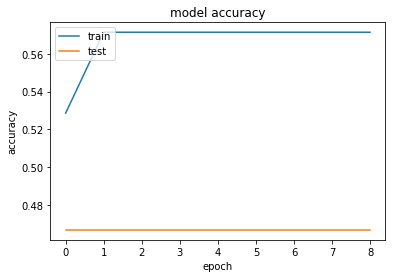

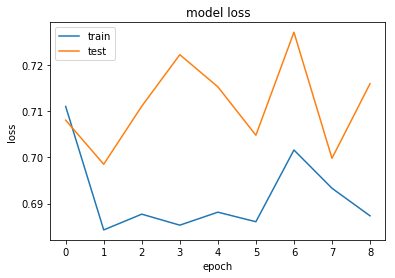

In [135]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()